# Endosymbiosis of _Sodalis_
This file is also present in https://github.com/drumfreakk/GBI_endosymbiosis where all other generated files are also present

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import math

# Quality Control

## GToTree Genomes_summary_info.tsv

We looked at the summary from GToTree to find out how complete the single copy genes in our genomes are compared to the GTDB. In particular, we tried to see whether complete genomes had different completeness and redundancy percentages than incomplete genomes.


In [2]:
species_df = pd.read_table("data/gtotree/Genomes_summary_info.tsv")
species_df["is_complete"] = ["Yes","No","Yes","Yes","Yes","Yes","No","Yes","Yes","Yes","Yes","No","Yes","No","No","No","No"]
species_df["is_endosymb"] = ["No","Yes","Yes","Yes","Yes","No","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","Yes"]

#species_df


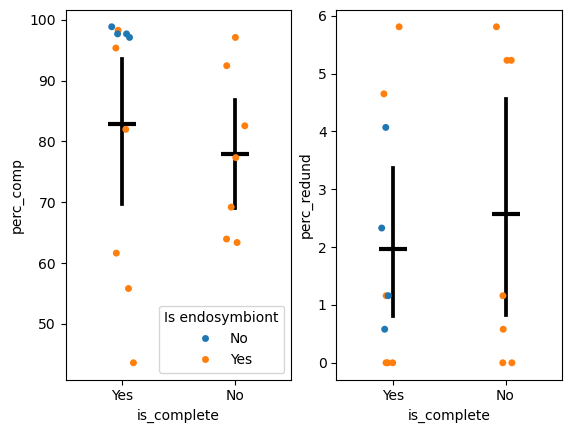

In [3]:
fig, axes = plt.subplots(1,2)

sns.stripplot(data=species_df,x="is_complete",y="perc_comp",hue="is_endosymb", ax = axes[0])
sns.pointplot(data=species_df,x="is_complete",y="perc_comp",linestyle="none",errorbar="ci",marker="_",markersize=20,markeredgewidth=3,ax=axes[0],color="black")

sns.stripplot(data=species_df,x="is_complete",y="perc_redund",hue="is_endosymb", ax = axes[1],legend=False)
sns.pointplot(data=species_df,x="is_complete",y="perc_redund",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[1],color="black")

handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend(title="Is endosymbiont", loc='lower right')

plt.tight_layout
plt.show()

The free-living, complete genomes have a completion percentage that's close to 100%. The endosymbiotic completed genomes can have completion percentages as low as 43%. Looking at the 95% CI error bars, there's no significant difference in completion percentage between complete and incomplete genomes. 

Redundancy percentages are generally below 6% and do not differ significantly between complete and incomplete genomes.



## Seqkit and Quast

We ran seqkit v2.10.0 and quast v5.0.0 on all of the genomes to generate more quality statistics, using the following commands:
```sh
mkdir quality
cd quality

seqkit stats -a ../data/genomes/* > seqkit_stats.tsv
sed -ie "s/[[:space:]]\+/\t/g" seqkit_stats.tsv
sed -ie "s/\.fna//g" seqkit_stats.tsv
sed -ie "s/,//g" seqkit_stats.tsv

for f in ../data/genomes/*; do mkdir quast_$f; quast -o quast_$f $f; done
for f in *.fna; do mv $f $(echo $f | cut -d"." -f1,2); done
```

In [4]:
seqkit_df = pd.read_table("quality/seqkit_stats.tsv")
species_seqkit_df = pd.merge(species_df, seqkit_df, left_on="assembly_id", right_on="file")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#species_seqkit_df

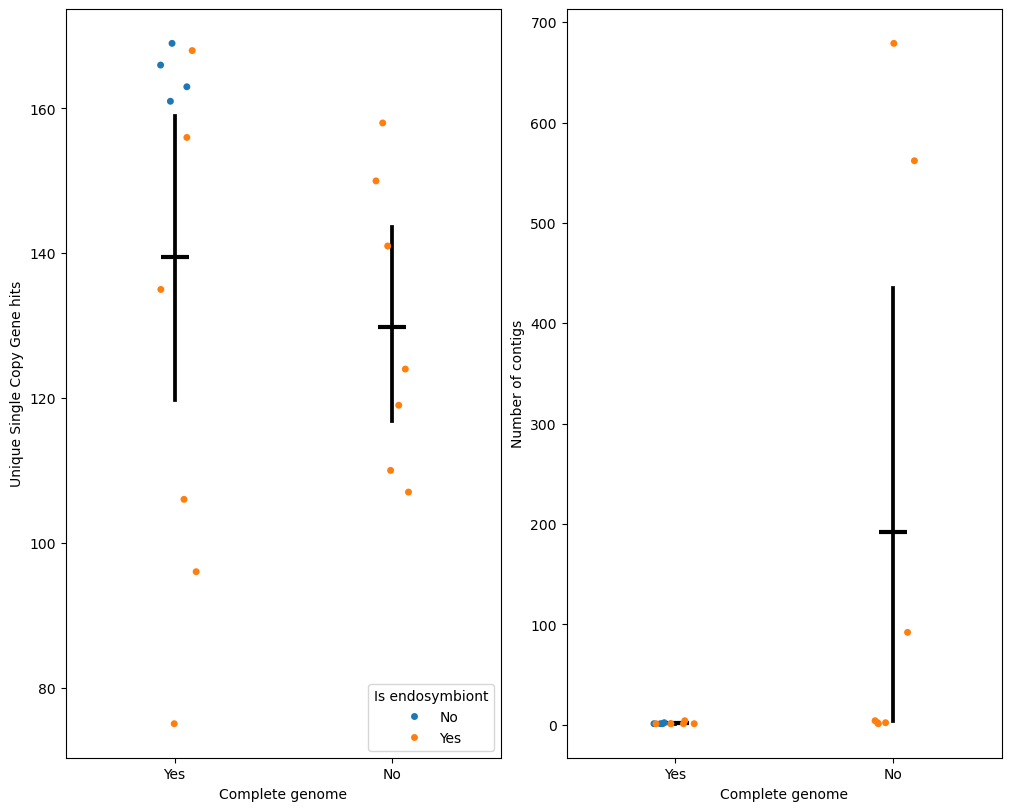

In [5]:
#fig, axes = plt.subplots(1,6,constrained_layout=True)
fig, axes = plt.subplots(1,2,constrained_layout=True)


sns.stripplot(data=species_seqkit_df,x="is_complete",y="uniq_SCG_hits",hue="is_endosymb", ax = axes[0])
sns.pointplot(data=species_seqkit_df,x="is_complete",y="uniq_SCG_hits",linestyle="none",errorbar="ci",marker="_",markersize=20,markeredgewidth=3,ax=axes[0],color="black")
axes[0].set(xlabel="Complete genome", ylabel="Unique Single Copy Gene hits")

#sns.stripplot(data=species_seqkit_df,x="is_complete",y="N50_num",hue="is_endosymb", ax = axes[1],legend=False)
#sns.pointplot(data=species_seqkit_df,x="is_complete",y="N50_num",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[1],color="black")

#sns.stripplot(data=species_seqkit_df,x="is_complete",y="GC(%)",hue="is_endosymb", ax = axes[2],legend=False)
#sns.pointplot(data=species_seqkit_df,x="is_complete",y="GC(%)",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[2],color="black")

#sns.stripplot(data=species_seqkit_df,x="is_complete",y="sum_len",hue="is_endosymb", ax = axes[3],legend=False)
#sns.pointplot(data=species_seqkit_df,x="is_complete",y="sum_len",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[3],color="black")

#sns.stripplot(data=species_seqkit_df,x="is_complete",y="N50",hue="is_endosymb", ax = axes[4],legend=False)
#sns.pointplot(data=species_seqkit_df,x="is_complete",y="N50",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[4],color="black")

sns.stripplot(data=species_seqkit_df,x="is_complete",y="num_seqs",hue="is_endosymb", ax = axes[1],legend=False)
sns.pointplot(data=species_seqkit_df,x="is_complete",y="num_seqs",linestyle="none", errorbar="ci", marker="_",markersize=20,markeredgewidth=3,ax=axes[1],color="black")
axes[1].set(xlabel="Complete genome", ylabel="Number of contigs")

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(title="Is endosymbiont", loc='lower right')

fig.set_size_inches(10, 8)
#plt.tight_layout
plt.savefig("figures/genome_QA.png", dpi=600, bbox_inches="tight")
plt.show()

Interestingly, the smallest genomes are marked as complete. Free-living species generally seem to have larger genomes, higher GC%, and more SCGs. To confirm this, we'll use a pooled t-test with unequal variances, with an alpha of 0.05.
There is also a large spread in N50 values, but (at least in the complete genomes) this is due to the difference in genome sizes, since the complete genomes are made up of only 1 or a few contigs, compared to the incomplete genomes which have many more.

In [6]:
endosymbiont = species_seqkit_df.loc[species_seqkit_df['is_endosymb'] == "Yes"]
free_living = species_seqkit_df.loc[species_seqkit_df['is_endosymb'] == "No"]
endosymbiont_complete = endosymbiont.loc[endosymbiont['is_complete'] == "Yes"]
free_living_complete = free_living.loc[free_living['is_complete'] == "Yes"]
print("Genome length:", stats.ttest_ind(endosymbiont_complete["sum_len"], free_living_complete["sum_len"], equal_var=False))
print("Unique SCG hits:", stats.ttest_ind(endosymbiont_complete["uniq_SCG_hits"], free_living_complete["uniq_SCG_hits"], equal_var=False))
print("GC(%):", stats.ttest_ind(endosymbiont["GC(%)"], free_living["GC(%)"], equal_var=False))

Genome length: TtestResult(statistic=np.float64(-3.4213571860576097), pvalue=np.float64(0.00956535107608002), df=np.float64(7.723131565657112))
Unique SCG hits: TtestResult(statistic=np.float64(-2.822074716053747), pvalue=np.float64(0.03589949131313596), df=np.float64(5.138946655919069))
GC(%): TtestResult(statistic=np.float64(-2.802659021903093), pvalue=np.float64(0.013422566284469082), df=np.float64(14.947693822688551))


All tests except GC(%) were performed only on the complete genomes, since incomplete genomes may cause anomalous values for genome size and content, that aren't representative of reality. These tests show that free-living species all have significantly higher genome lengths, unique SCG hits and GC(%) values than endosymbiotic species. It makes sense that they have longer genomes and higher SCG hits, since free-living species need all genes required for survival, whereas endosymbiotic species generally make use of the host's environment and enzymes. 

It might be possible that the different GC% is to improve stability of the genome in free-living species, but that's basically a guess at this point. We might be able to confirm this using GenomeSpot.

```sh
mkdir GenomeSpot
for f in data/genomes/*; do prodigal -i $f -a GenomeSpot/`basename ${f/.fna/.faa}`;done
cd GenomeSpot
python3.11
for f in *faa; do python -m genome_spot.genome_spot --models ~/data_bb3bcg20/bin/GenomeSPOT/models/ \
  --contigs ../data/genomes/${f/.faa/.fna} \
  --proteins $f \
  --output $f.genome_spot \
; done
echo "assembly_id\tpredicted_optimum_temp\tpredicted_temp_error" > temperatures.tsv
for f in *.tsv; do echo "${f/.faa.genome_spot.predictions.tsv/}" `grep -e "temperature_optimum" $f | cut -f2,3` >> temperatures.tsv; done
sed -ie "s/ /\t/g" temperatures.tsv
```
The version of Prodigal was V2.6.3 and of GenomeSpot 1.0.1

All predicted optimum temperatures seem to be fairly similar. Maybe we can do some more statistics to correlate the two, but for now we'll carry on with other things.

In [7]:
temperature_df = pd.read_table("GenomeSpot/temperatures.tsv")
temperature_df

,assembly_id,predicted_optimum_temp,predicted_temp_error
0,Sodalis_sp_TME1_GCA_001879235.1,31.968493,5.617930
1,Dickeya_dadantii_XJ12_GCF_030168535.1,30.979555,5.603338
2,Doolittlea_endobia_DEMHIR_GCF_900039485.1,37.485427,6.984910
3,Gullanella_endobia_GEFVIR_GCF_900048035.1,41.538674,7.712780
4,Mikella_endobia_mEPMAR_GCF_900048045.1,NaN,NaN
5,Moranella_endobia_GCF_000364725.1,42.333827,7.805572
6,Pectobacterium_cacticida_CFBP3628_GCF_036885195.1,28.326717,5.700592
7,Sodalis_endolongispinus_SOD1_GCF_018777395.1,31.235512,5.617332
8,Sodalis_glossinidius_morsitans_GCF_000010085.1,29.374622,5.682838
9,Sodalis_ligni_dw23_GCF_016865525.2,29.941791,5.670055


# Phylogeny

Here we try to make a phylogeny from the concatenated SCGs in Aligned_SCGs.faa. We will first run IQtree without trimming the alignment, and then compare the result with a trimmed alignment.

## Running IQ-TREE 2.3.6 without trimming
As a first test, we ran 

```f=Aligned_SCGs.faa```

```iqtree -s $f -m LG+G4+F -pre $f.LGG4F``` (that takes a long time fml)

This showed the alignment has 38047 amino-acid sites, of which 8540 were parsimony-informative, 10379 were singleton sites, and 19127 were constant sites. 

There was also one sequence, Mikella_endobia_mEPMAR_GCF_900048045.1, that was formed by more than 50% gaps. However, we will not remove this sequence, because it's complete and might've lost many genes as an endosymbiont.

We viewed the obtained Aligned_SCGs.faa.LGG4F.treefile in figtree and rooted between Sodalis and the two related species (Dickeya and Pectobacterium). We based this root on _The genus Sodalis as a resource for understanding the multifaceted evolution of bacterial symbiosis in insects._ ([1](https://doi.org/10.1007/s13199-023-00966-0)). 

![alt text](figures/Aligned_SCPs.faa.LGG4F.treefile.png "Title")

The obtained tree looks similar to the tree in the publication, so it should generally be in the right direction.

## With trimming
To trim the sites containing over 50% gaps, we ran trimAl v1.5.rev0:

```trimal -in Aligned_SCGs.faa -out Aligned_SCGs.faa.trimal05 -gt 0.5```

We then ran IQ-TREE again, but now with more threads

```ft=Aligned_SCGs.faa.trimal05```

```iqtree -s $ft -m LG+G4+F -nt AUTO -pre $ft.LGG4F```

This showed that the trimmed alignment has 30635 sites, with 7459 parsimony-informative sites, 8861 singleton sites and 14315 constant sites.

![alt text](figures/Aligned_SCGs.faa.trimal05.LGG4F.treefile.png "Trimmed")

This tree looks identical to the tree from the untrimmed alignment, so trimming doesn't seem to make a difference. However, we will carry on with the analysis using the trimmed alignment, as this is hopefully faster to run.

## Model search
We tried to find an optimal model to produce a good phylogenetic tree using:

```ft=Aligned_SCGs.faa.trimal05```

```iqtree -s $ft -m MFP -nt AUTO -pre $ft.bestmodel```

-m MFP tries to find the optimal substitution model, and -nt AUTO the optimal number of threads. 

The best model according to the model finder was Q.plant+R4, as outlined in Aligned_SCGs.faa.trimal05.bestmodel.iqtree. 

!["blah"](figures/Aligned_SCGs.faa.trimal05.bestmodel.treefile.png "Title")

The resulting tree was identical to the tree produced from the LGG4F model. The plant model being best does not make a lot of sense, but the earlier trees might've already been fully solidified due to the long alignments, so the model might not matter much. However, this does not mean the tree is perfect as artefacts might still occur.

Sodalis ligni is placed at the base of the clade containing all Sodalis species, pointing to a free-living LCA of Sodalis.

Most of the Sodalis-allied species cluster together, except for Moranella, which clusters with Sodalis sp. strain HBA. Furthermore, Sodalis sp. strain CWE clusters within a clade containing CWE, Mikella, Gullanella, and Doolittlea. This tree could be correct, but since the Sodalis-allied species have fairly long branches, their placement together might also be a result of long branch attraction.

Interestingly, S. praecaptivus, a free-living species, is placed within a clade of endosymbiotic Sodalis species. This could mean that the LCA of the clade containing S. praecaptivus and Moranella was not endosymbiotic and multiple endosymbiotic events occurred. Alternatively, the LCA could already have been endosymbiotic to some extent, with S. praecaptivus reverting those changes to become free-living again.

One way to get an insight into the evolutionary history of Sodalis, is to compare the phylogeny with a phylogeny of the hosts.

## Phylogenetic tree of host species
We decided to build a phylogeny of the host species in the hopes of finding out when endosymbiotic events likely occurred and how many of them.

To build the phylogeny, we used mitochondrial 12S rRNA sequences with the accession codes in host-tree/12S_names. We didn't use full genomes as we estimated that would take a long time to download and process, and take up a lot of space. The 12S gene was also one of the only genes that was sequenced for all host organisms and that is suitable for constructing phylogenies over long evolutionary distances. The selected sequences also include some partial or complete mitochondrial genomes, which might have to be trimmed for the alignment to work well.

### Downloading the sequences

```sh
cat 12S_names | while read f;  do wget -q -O - "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nuccore&id=$f&rettype=fasta";  done > 12S_genes.frn
```
We used this loop to download all the sequences with the identifiers from 12S_names and concatenate them into 12S_genes.frn.

### Aligning the sequences with MAFFT v7.525

We first ran ```mafft 12S_genes.frn > 12S_genes.frn.mafft``` to align the sequences. However, the 12S rRNA sequences were very fragmented when mapped against the mitochondrial contigs of some other species. To combat this, we tried running MAFFT with iterative refinement: ```mafft --auto --thread -1 12S_genes.frn > 12S_genes.mafft_auto```. MAFFT used the FFT-NS-2 alignment strategy, which progressively aligned two times, but the alignment was still very fragmented.

### Trying to extract 12S sequences from mitochondrial contigs with BLASTn 2.15.0+
We tried to extract 12S sequences from the mitochondrial contigs by running 
```sh
cat 12S_names|while read id; do blastn -query $id.frn -db 12S_genes.frn -dust no -task blastn -subject_besthit -out "$id"_vs_12S.blastn; done;
```
but this didn't give significant hits between all sequences. Some sequences, like EF678869.1, did not give significant alignments against other sequences at all. Because there wasn't enough time to figure out the cause of the missing hits, we decided to move on and make a host phylogeny manually.

## Manual phylogeny

To create a phylogeny, we looked up the binomial names for all host species and placed them in an [insect tree](https://doi.org/10.1016/j.cub.2021.08.057). To resolve the hemipteran insects, we used a [more detailed tree](https://doi.org/10.1016/j.ympev.2019.05.009). Mealybugs were resolved using a [tree for Coccomorpha](https://doi.org/10.1111/syen.12534), where the genus Llaveia falls within the outgroup. The result is displayed in the figure below. ![alt text](figures/host-phylogeny-draft.png "Title") 

Note that the genus Columbicola is wrongly placed with the Neuroptera and should be placed with the Phthiraptera instead. This has been fixed in the final tanglegram.

## Manual tanglegram

We made a Newick file for the host phylogeny, as well as for the endosymbiotic Sodalis(-allied) species. These can be found in ~/host-tree/Host_taxonomy.newick and ~/host-tree/Endosymbionts_tree.newick, respectively. The files were imported in FigTree v1.4.4, and branches were colored according to their corresponding host/endosymbiont. The trees can be found in ~/host-tree/colored-hosts and ~/host-tree/colored-sodalis, respectively. The two trees were then placed together using a painting program, and the host tree flipped. Lines were drawn between corresponding hosts and endosymbionts. The incorrect placement of Columbicola has been fixed by manually moving branches in the host tree. The result is shown below: ![.](figures/tanglegram.png ".")

There seems to be no association between clades in the host tree and the Sodalis tree. This points to a scenario where Sodalis is a widely present facultative (endo)symbiont that has recently become an obligate endosymbiont in some host species, as outlined in [this paper](https://doi.org/10.3389/fmicb.2021.668644) and [this paper](https://doi.org/10.1186/s40851-014-0009-5). 

# 16S rRNA phylogeny

16S rRNA sequences were obtained by first running Prokka 1.14.6 on all genomes:

```sh
f="name of genome file".fna
filename=$(basename $f);
name=${filename%.fna};
prokka_ed -o prokka_$name --prefix $name --locustag $name --kingdom Bacteria --metagenome --cpus 2 $f
```

The 16S sequences of each file were then extracted by combining a grep command with seqtk:

```sh
grep 16S\ ribosomal\ input | sed "s/ .*//" | sed "s/>//" > rRNA_list_ 
seqtk subseq "name of file".ffn rRNA_list_ > rRNA_list.frn
```
A total of 71 rRNA sequences were found through this technique of which 11 were partial. For both untrimmed and trimmed 16S rRNA sequences, alignments were made by concatenating the files and using mafft v7.525.

In the following step iqtree2 version 2.3.6 was performed for the untrimmed 16S rRNA sequences:

```sh
f=mafft_16S_align_nd 
iqtree2 -s $f -m GTR+G4 -pre $f.GTRG4
```

![alt text](figures/16S_rRNA1.png)

The tree that resulted is very messy and unreadable which is why we chose to collapse the 16s rRNA sequences per species. Sequences were collapsed when they shared 99% identity. From 71 rRNA sequences 26 remained:

```sh
mkdir -p clustered_output

for file in rRNA_list*.frn; do
    base=$(basename "$file" .frn)
    cd-hit -i "$file" -o "clustered_output/${base}_cdhit" -c 0.99 -n 5
done
```

![alt text](figures/16S_rRNA_tree_collapsed.png)

In the tree you can see that most of the sequences have been concatenated except for the sequences belonging to Sodalis ligni (free living) and Sodalis pierantonius (endosymbiont). We chose to leave it unrooted as this tree is only used to see how similar the sequences are to each other. As Sodalis Ligni is a free-living species it makes sense that there are still multiple copies of the same gene. However, Sodalis Pierantonius is an endosymbiont. In the species tree Pierantonius is still fairly close to the root and so it should have had time to lose duplicate genes. It coud be possible that Pierantonius has not yet lost the gene that is needed to have recombination. 

# Mummer

To check how much the genomes have diverged from one another, synteny between species was checked by making mummerplots. Additionally we checked how similar the two additional genomes were to each other. As we use genomes of different species, promer version 3.07 was used instead of nucmer. Mummerplot 3.5 was then used to get a visualisation:

```sh
promer --maxmatch -p "output_name" "Genome_file_1".fna "Genome_file_2".fna
mummerplot --color "output_name".delta --png -p "new_output_name"
```

A total of six different mummerplots were generated:

- Sodalis sp. strain CWE vs Mikella endobia strain MEPMAR
- Dickeya dadantii strain X112 vs Pectobacterium cacticida strain CFBP3628
- Mikella endobia strain MEPMAR vs Sodalis ligni strain dw23
- Sodalis pierantonius strain SOPE vs Sodalis praecaptivus strain HS1
- Mikella endobia strain MEPMAR vs Sodalis ligni strain dw23
- Sodalis sp. strain Et.F2 vs Sodalis pierantonius strain SOPE

These combinations were chosen as all genomes except for Sodalis sp. strain CWE had complete genomes which resulted in readable mummerplots.

Comparison of two most recent species according to the tree:
- Sodalis sp. strain CWE vs Mikella endobia strain MEPMAR

Comparison  free-living and free-living:
- Dickeya dadantii strain X112 vs Pectobacterium cacticida strain CFBP3628

Comparison endosymbionts and free-living species could be compared:
- Moranella endobia strain PCVAL vs Sodalis ligni strain dw23
- Mikella endobia strain MEPMAR vs Sodalis ligni strain dw23

Comparison within the same clade: 
- Sodalis sp. strain Et.F2 vs Sodalis pierantonius strain SOPE
- Sodalis pierantonius strain SOPE vs Sodalis praecaptivus strain HS1

Sodalis sp. strain CWE vs Mikella endobia strain MEPMAR

![alt text](figures/CWEvsMikella.delta.png)

There is no clear synteny to be seen but they are closely related together in the tree and furthest away from the root. 

Dickeya dadantii strain X112 vs Pectobacterium cacticida strain CFBP3628

![alt text](figures/DickeyavsPecto.delta.png)
In the bottom right and top left a bit of synteny can be seen. These pieces of synteny probably show important proteins needed for basic function.

Moranella endobia strain PCVAL vs Sodalis ligni strain dw23

![alt text](figures/MoranellavsLigni.delta.png)

No synteny can be seen. This is probably as Ligni is a free living species and Moranella is an endosymbiont from a different genus.

Mikella endobia strain MEPMAR vs Sodalis ligni strain dw23

![alt text](figures/MikellavsLigni.delta.png)

Here too no clear synteny can be seen. This is logical as one is free living and the other is an endosymbiont. Additionally they do not appear to be close on the species tree.

Sodalis sp. strain CWE vs Mikella endobia strain MEPMAR


![alt text](figures/CWEvsMikella.delta.png)

There is no clear synteny to be seen but they are closely related together in the tree and furthest away from the root. 

Sodalis sp. strain Et.F2 vs Sodalis pierantonius strain SOPE

![alt text](figures/EtF2vspierantonius.delta.png)

A bit of synteny can be seen which is logical as they are from within the same clade.

Sodalis pierantonius strain SOPE vs Sodalis praecaptivus strain HS1

![alt text](figures/PierantoniusvsPraecaptivus.delta.png)

There is synteny as they are in the same clade but there is also a horizontal line, possibly repeats or mobile elements.

# Gene Annotation

In this section, we use COG annotations of genes (generated by prokka) to determine the amount of genes for different functions in three different categories of species: free-living, symbiotic with complete genomes and symbiotic with incomplete genomes. All free-living species sampled had complete genomes, so no subdivision was necessary for those.

First, we pre-process the output of prokka (to be specific, the `.gff` files): 
```sh
mkdir genes
cd genes

for f in ../prokka/prokka_*; do \
grep --color=never -e "COG" $f/`basename ${f/prokka_/}`.gff | cut -f9 > `basename ${f/prokka_/}`; 
done

find . -type f | perl -pe 'print $_; s/_\d{9}_\d//' | xargs -d "\n" -n2 mv
find . -type f | perl -pe 'print $_; s/_GC.//' | xargs -d "\n" -n2 mv
```
These commands get the attribute lists from the `.gff` files, and rename the files to just be the species names.
Then, the following script gets the COG annotations for each species, and counts the number of genes in each category for each species.

Then, we use the following python scripts to import the data, select the genes with COG annotations, and count the number of genes in each COG category per species. We also plot the total number of (COG annotated) genes per species. The data is split on symbiotic and free-living species, since we suspect that there will be a difference in these categories. 

In [8]:
# Use a new copy of the dataframe
species_abbrv_df = species_df
# Make sure the species names are the same as the filenames
species_abbrv_df["assembly_id"] = species_abbrv_df["assembly_id"].apply(lambda name: '_'.join(name.split("_")[:-2]))

# Import the COG annotations into a dataframe
cog = pd.read_table("data/functional_information/cog-20.def.tab", names=["ID", "CATEGORY", "NAME", "SYMBOL", "PATHWAYS", "PUBMED", "PDB"], encoding="latin")

# Import the COG category descriptions into a dataframe
cog_cats = pd.read_table("data/functional_information/fun-20.tab", names=["CATEGORY", "??", "CATEGORY_DESCRIPTION"])

# Import the attributes from the gff files into a dataframe
data = {}
species = os.listdir("genes")

# Iterate through each species
# I know specy isn't the right singular of species, but otherwise the variables would be called the same
for specy in species:
        i = 0
        with open("genes/"+specy, "r") as file:
                for line in file:
                        attrs_linked = line.strip().split(";")
                        attrs = [["Species",specy]] + [i.split("=") for i in attrs_linked]
                        had_keys = []
                        for keyval in attrs:
                                if keyval[0] == "db_xref":
                                        # The COG values should be split up a bit more to make life easier later on
                                        keyval[0] = "cog_id"
                                        keyval[1] = keyval[1].split(":")[1]
                                if keyval[0] in data:
                                        # There is already a column for this key, so just append the value
                                        data[keyval[0]].append(keyval[1])
                                else:
                                        # There isn't a column for this key yet, so create one and fill it up with empty strings
                                        # This makes sure the indexing keeps working
                                        data[keyval[0]] = [keyval[1] if j==i else "" for j in range(i+1)]
                                had_keys.append(keyval[0])
                        for key in list(set(data.keys()).difference(had_keys)):
                                # If a previously used key didn't appear in this line, add an empty string to keep indexing working
                                data[key].append("")
                        i+=1

# Turn the dictionary into a dataframe
genes = pd.DataFrame.from_dict(data)

# Add the COG annotations to the gff annotations
genes = genes.join(cog.set_index("ID"), on="cog_id")
#genes

In [9]:
# Count the number of genes in each COG category for each species
# I'm sure there must be a prettier way to do this, but it seems to work
categories = list(cog_cats["CATEGORY"])
columns = ["Species", "Total"] + categories
counts = {}
for i in columns:
        counts[i] = [0]
counts = pd.DataFrame.from_dict(counts)

def get_gene_category_counts(species):
        counts = {}
        for i in columns:
                counts[i] = [0]

        counts["Species"] = species
        for index, row in genes.loc[genes['Species'] == species].iterrows():
                for category in row["CATEGORY"]:
                        counts[category][0] += 1
                counts["Total"][0] += 1
        return pd.DataFrame.from_dict(counts)

for specy in species:
        count = get_gene_category_counts(specy)
        counts = pd.concat([counts, count], ignore_index=True)

counts = counts.drop(0)

counts = counts.join(species_abbrv_df[["assembly_id","is_complete","is_endosymb"]].set_index('assembly_id'), on='Species')
# Now counts is a dataframe with a row per species, 
# with columns for the amount of genes in a given COG category, and whether they are complete and/or endosymbiotic

# Annotate the types a bit better
counts.loc[(counts['is_complete'] == "Yes") & (counts['is_endosymb'] == "Yes"), 'Type'] = 'Symbiont (complete)'
counts.loc[(counts['is_complete'] == "No") & (counts['is_endosymb'] == "Yes"), 'Type'] = 'Symbiont (incomplete)'
counts.loc[counts['is_endosymb'] == "No", 'Type'] = 'Free-living'

print("Individual counts per gene category per species")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#counts


Individual counts per gene category per species


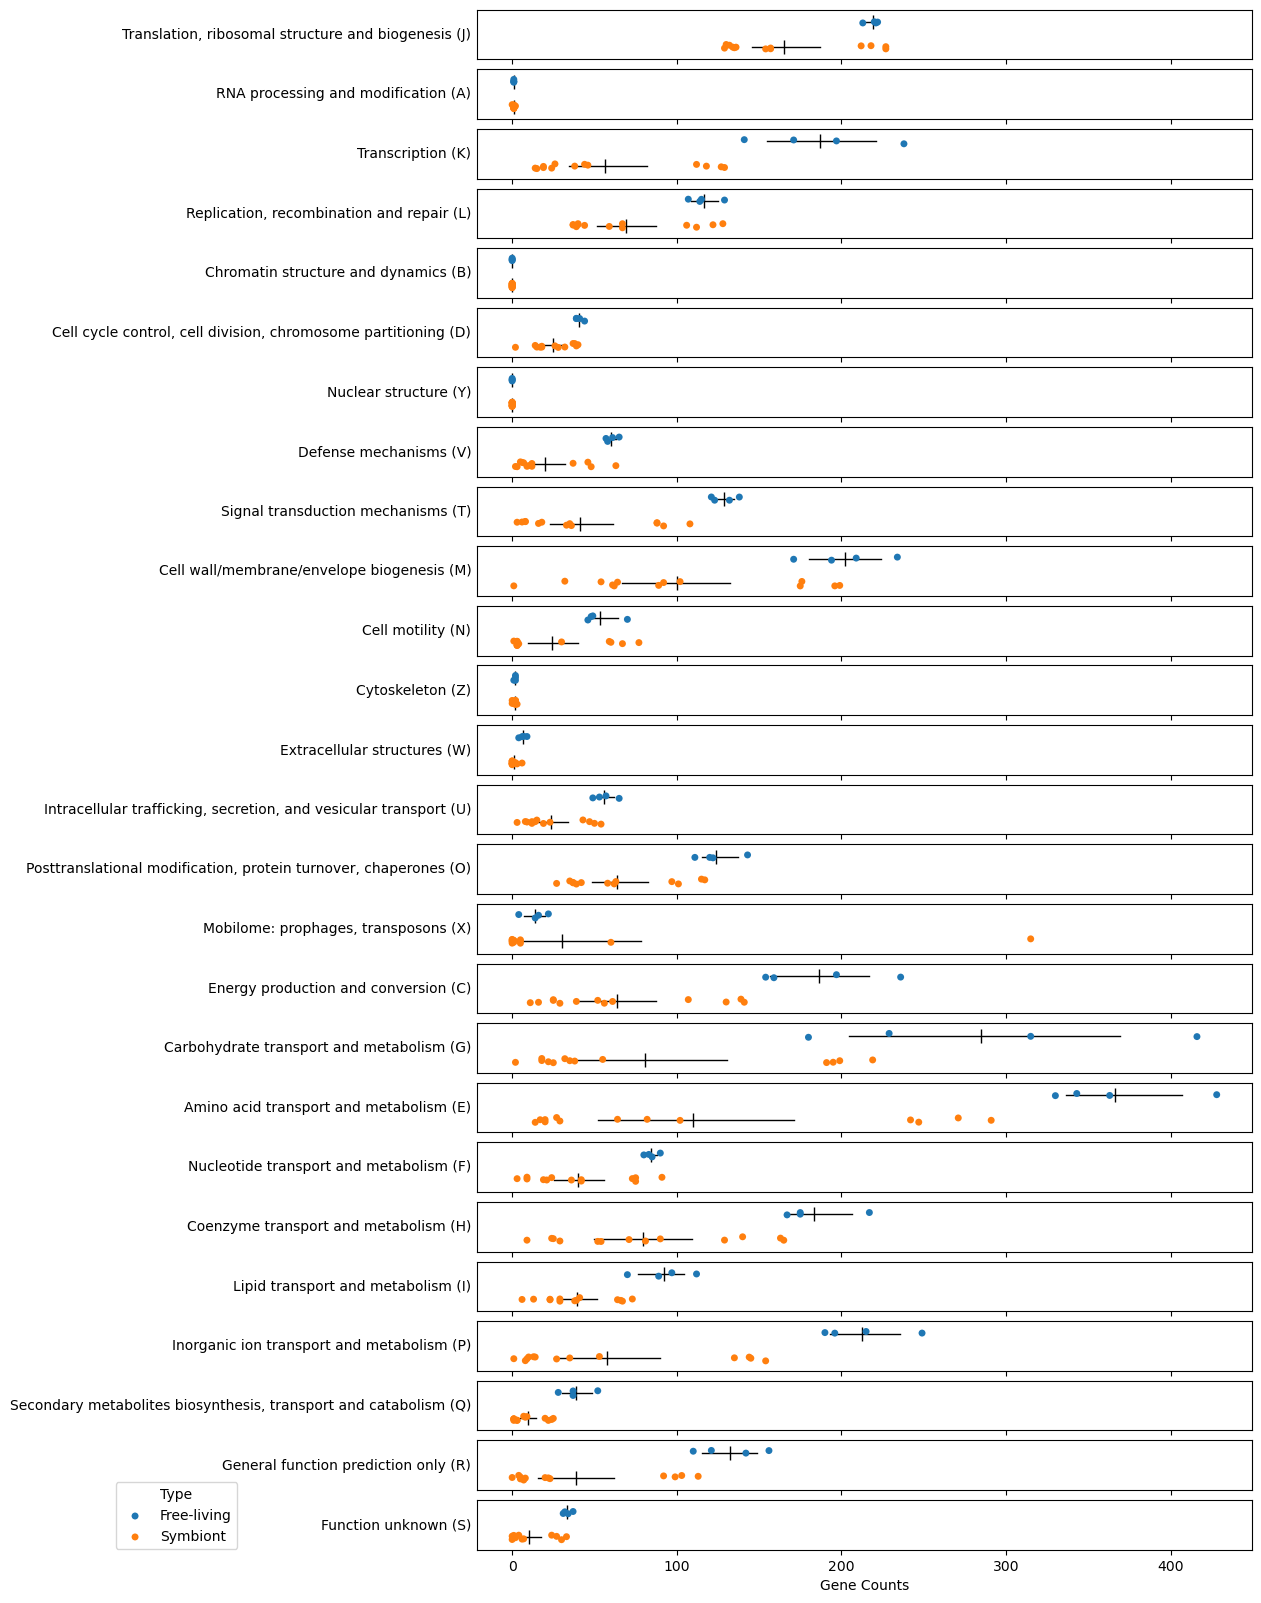

In [10]:
fig, axes = plt.subplots(len(categories), 1, figsize = (10,20), sharex=True)
for i in range(len(categories)):
    sns.stripplot(data=counts,y="is_endosymb",x=categories[i], hue="is_endosymb", ax = axes[i])
    sns.pointplot(data=counts,y="is_endosymb",x=categories[i],linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes[i],color="black", err_kws={'linewidth':1})

    axes[i].set_ylabel(cog_cats["CATEGORY_DESCRIPTION"][i] + " (" + categories[i] + ")", rotation=0, ha="right", va="center")
    axes[i].set_xlabel("Gene Counts")
    axes[i].set_yticks([])

# Since this legend is hardcoded, but the order in which the data is presented isn't, 50/50 whether the legend is correct or not
# You can manually check whether its correct by looking at the amount of dots, the free-living sholud have 4 species
# Because this isn't that big of an issue really if you pay a bit of attention, I'm not going to bother fixing it 
axes[-1].legend(["Free-living", "Symbiont"], title="Type", bbox_to_anchor=(-0.3, 1.5))
plt.tight_layout
plt.savefig("figures/gene_counts.png", dpi=600, bbox_inches="tight")
plt.show()


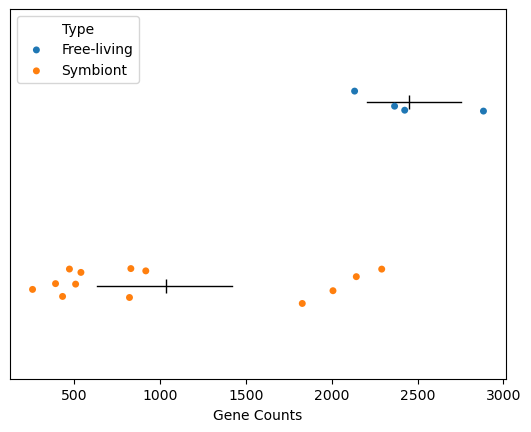

In [11]:
fig, axes = plt.subplots(1,1)

sns.stripplot(data=counts,y="is_endosymb",x="Total", hue="is_endosymb", ax = axes)
sns.pointplot(data=counts,y="is_endosymb",x="Total",linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes,color="black", err_kws={'linewidth':1})

axes.set_ylabel("")
axes.set_xlabel("Gene Counts")
axes.set_yticks([])

axes.legend(["Free-living", "Symbiont"], title="Type", loc="upper left")
plt.tight_layout
plt.savefig("figures/gene_counts_total.png", dpi=600, bbox_inches="tight")
plt.show()

We see that in general, the symbiotic species have less genes than the free-living species, but there are a few species which have similar amounts of genes, and a few other categories (A, Z and X in particular) which vary or show other interesting behaviour. There are no genes found in the B and Y categories (nuclear & chromatin structure), which makes sense since we are looking at bacteria. 

The next block of code will find the outliers in each category, using a CI of 95%

In [12]:
outliers = {}
for cat in categories:
    mean = counts.loc[counts['is_endosymb'] == "Yes", cat].mean()
    std = counts.loc[counts['is_endosymb'] == "Yes", cat].std()
    count = counts.loc[counts['is_endosymb'] == "Yes", cat].count()
    outlier_from = mean + 1.96*std/math.sqrt(count)
    outliers_cat = counts.loc[(counts[cat] >= outlier_from) & (counts["is_endosymb"] == "Yes"), "Species"]
    for outlier in outliers_cat:
        outliers[outlier] = outliers.get(outlier, 0) + 1
#    print("Outliers in " + cat + ":", list(outliers_cat))
    
mean = counts.loc[counts['is_endosymb'] == "Yes", "Total"].mean()
std = counts.loc[counts['is_endosymb'] == "Yes", "Total"].std()
count = counts.loc[counts['is_endosymb'] == "Yes", "Total"].count()
outlier_from = mean + 1.96*std/math.sqrt(count)
outliers_cat = counts.loc[(counts["Total"] >= outlier_from) & (counts["is_endosymb"] == "Yes"), "Species"]
print("Outliers in total gene count:", list(outliers_cat))
#for outlier in outliers_cat:
#    outliers[outlier] = outliers.get(outlier, 0) + 1

print("Number of times a species is an outlier in a category: ", outliers)

Outliers in total gene count: ['Sodalis_endolongispinus_SOD1', 'Sodalis_glossinidius_morsitans', 'Sodalis_pierantonius_SOPE', 'Sodalis_sp_TME1']
Number of times a species is an outlier in a category:  {'Sodalis_endolongispinus_SOD1': 23, 'Sodalis_glossinidius_morsitans': 23, 'Sodalis_pierantonius_SOPE': 24, 'Sodalis_sp_TME1': 22, 'Sodalis_sp_HBA': 3, 'Doolittlea_endobia_DEMHIR': 2, 'Gullanella_endobia_GEFVIR': 2, 'Mikella_endobia_mEPMAR': 2, 'Moranella_endobia': 2, 'Sodalis_sp_CWE': 2, 'Sodalis_sp_EtF2': 2, 'Sodalis_sp_PSPU': 3, 'Sodalis_sp_SPI-1': 3}


We can see that S. endolongispinus, S. glossinidius morsitans, S. pierantonius and S. sp TME1 in particular have consistently more genes than expected of symbiotic species, and are more like the free-living species.

Now we will look at the X (Mobilome, transposons & prophages) category. Here we see that S. glossinidius morsitans and S. pierantonius have a lot more genes than all other species. This might be related to the horizontal line we see in the mummerplot of Sodalis pierantonius strain SOPE vs Sodalis praecaptivus strain HS1.

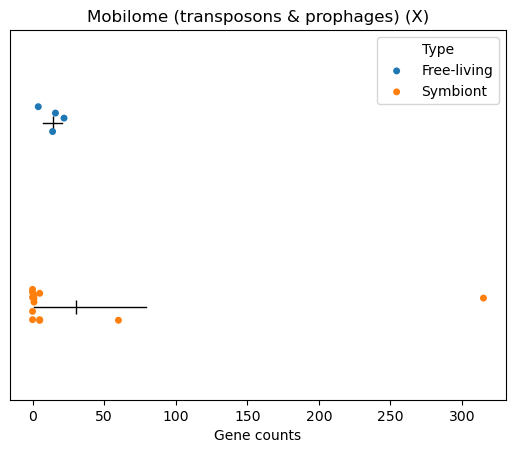

In [13]:
fig, axes = plt.subplots(1, 1)

sns.stripplot(data=counts,y="is_endosymb",x="X", hue="is_endosymb", ax = axes)
sns.pointplot(data=counts,y="is_endosymb",x="X",linestyle="none",errorbar="ci",marker="|",markersize=10,markeredgewidth=1,ax=axes,color="black", err_kws={'linewidth':1})
axes.set(xlabel="Gene counts", ylabel="")
axes.set_yticks([])
plt.title("Mobilome (transposons & prophages) (X)")
axes.legend(["Free-living", "Symbiont"], title="Type", loc='upper right')
plt.tight_layout
plt.savefig("figures/mobilome_gene_counts.png", dpi=600, bbox_inches="tight")
plt.show()


In [14]:
print(genes.loc[genes["CATEGORY"].str.contains("A")][["Species", "cog_id", "NAME", "SYMBOL"]])
print(genes.loc[genes["CATEGORY"].str.contains("Z")][["Species", "cog_id", "NAME", "SYMBOL"]])

                                 Species   cog_id  \
790                Dickeya_dadantii_XJ12  COG1949   
2700           Doolittlea_endobia_DEMHIR  COG1949   
3061           Gullanella_endobia_GEFVIR  COG1949   
3738                   Moranella_endobia  COG1949   
5780   Pectobacterium_cacticida_CFBP3628  COG1949   
6733        Sodalis_endolongispinus_SOD1  COG1949   
8467      Sodalis_glossinidius_morsitans  COG1949   
12605                 Sodalis_ligni_dw23  COG1949   
13716          Sodalis_pierantonius_SOPE  COG1949   
17359           Sodalis_praecaptivus_HS1  COG1949   
18034                     Sodalis_sp_CWE  COG1949   
18934                    Sodalis_sp_EtF2  COG1949   
19478                     Sodalis_sp_HBA  COG1949   
19479                     Sodalis_sp_HBA  COG1949   
20378                    Sodalis_sp_PSPU  COG1949   
21256                   Sodalis_sp_SPI-1  COG1949   
23194                    Sodalis_sp_TME1  COG1949   

                                            N

All RNA-related genes are COG1949, Oligoribonuclease (3'-5' exoribonuclease), and all cytoskeleton-related genes are MreB and MreC, Cell shape-determining ATPase MreB, actin-like superfamily and Cell shape-determining protein MreC respectively.

It looks like this might not be entirely true, since GToTree found (for example) MreD as well in most species, whereas prokka clearly did not (or at least didn't annotate it). This might be due to a limitation on the part of prokka, but considering we don't have particularly better ways of doing this, and most other categories have a lot more entries in them, we will still trust it.